After spending a lot of time in Kerbal Space Program (KSP), a video game where you build rockets and explore the solar system it had me interested in exploring our own solar system. In KSP


Data Source: https://ssd.jpl.nasa.gov/sbdb_query.cgi#x

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler
from scipy.special import boxcox1p
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling  import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

Reading in the data and examine the first few lines.

In [2]:
NEO_df = pd.read_csv('NEO2.csv') #NEO = Near Earth Object
NEO_df.head()

C:\Users\JT\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,4,5,16,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,G,...,e,a,q,i,om,ma,ad,n,moid,moid_ld
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,0.12,...,0.077557,2.767657,2.553006,10.588621,80.286986,162.686252,2.982308,0.214060,1.58865,618.254921
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,0.11,...,0.229972,2.773841,2.135935,34.832932,173.024741,144.975678,3.411748,0.213345,1.23429,480.348639
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,0.32,...,0.256936,2.668285,1.982706,12.991044,169.851481,125.435354,3.353865,0.226129,1.03429,402.514639
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,0.32,...,0.088721,2.361418,2.151909,7.141771,103.810804,95.861938,2.570926,0.271609,1.13948,443.451432
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,NaN,...,0.190913,2.574037,2.082619,5.367427,141.571026,17.846339,3.065455,0.238661,1.09575,426.433028


# Exploratory Data Analysis

In [3]:
NEO_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961868 entries, 0 to 961867
Data columns (total 37 columns):
id                961868 non-null object
spkid             961868 non-null int64
full_name         961868 non-null object
pdes              961868 non-null object
name              25579 non-null object
prefix            3646 non-null object
neo               958416 non-null object
pha               937052 non-null object
H                 952006 non-null float64
G                 119 non-null float64
M1                1400 non-null float64
M2                972 non-null float64
K1                1400 non-null float64
K2                972 non-null float64
PC                948 non-null float64
diameter          136315 non-null float64
extent            20 non-null object
albedo            135124 non-null float64
rot_per           18817 non-null float64
GM                14 non-null float64
BV                1021 non-null float64
UB                979 non-null float64
IR      

Looks like there's quite a few missing values in some of the columns. For the columns with very few observations, I will be dropping them as inference/imputing missing values would be very difficult and provide little benefit.

#### Data Dictionary:

full_name : full name of object  
pdes: object primary designation  
name: name of object  
prefix: Comet type (see https://en.wikipedia.org/wiki/Naming_of_comets for more info)  
neo: Near Earth Object Indicator  
pha: Potentially hazardous asteroid  
H: absolute magnitude param  
G: magnitude slope param  
M1: Comet total magnitude param  
M2: Comet nuclear magnitude param  
K1: comet total magnitude slope parameter  
K2: comet nuclear magnitude slope param  
PC: comet nuclear magnitude law- phase coeff  
diameter: diameter of object in km  
extent: object bi/tri-axial ellipsoid dimensions (km)  
albedo: geometric albedo   
rot_per: rotation period  
GM: standard gravitational param (product of mass and gravitational constant  
BV: color index B-V magnitude difference  
UB: color index U-B magnitude difference  
IR: color index I-R magnitude difference  
spec_B: spectral taxonomic type (SMASSII)  
spec_T: spectral taxonomic type (Tholen)  
H_sigma: 1-sigma uncertainty in absolute magnitude H  
diameter_sigma: 1-sigma uncertainty in object diameter (km)  

I'm going to drop some columns that will not be used in the analsys as they are not particularly useful. Additionally, I will drop the columns where I noticed there are extremely few populated values, and I will take care and examine the remaining columns later. I am also not interested in the name of the object, just it's features.

In [4]:
NEO_df.drop(['id', 'spkid', 'name', 'full_name', 'IR','extent','prefix','G','IR','GM', 'pdes'], axis=1, inplace=True)

Taking a look at the distribution of each column

C:\Users\JT\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


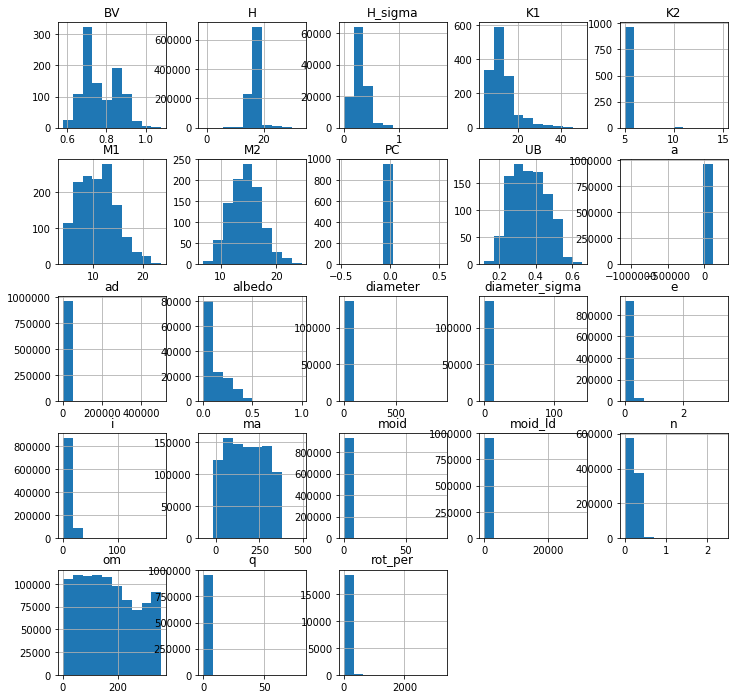

In [5]:
fig= plt.figure(figsize=(12,12))
ax = fig.gca();
NEO_df.hist(ax = ax);

Looking at the interactions of variables below

In [6]:
#sns.pairplot(NEO_df)

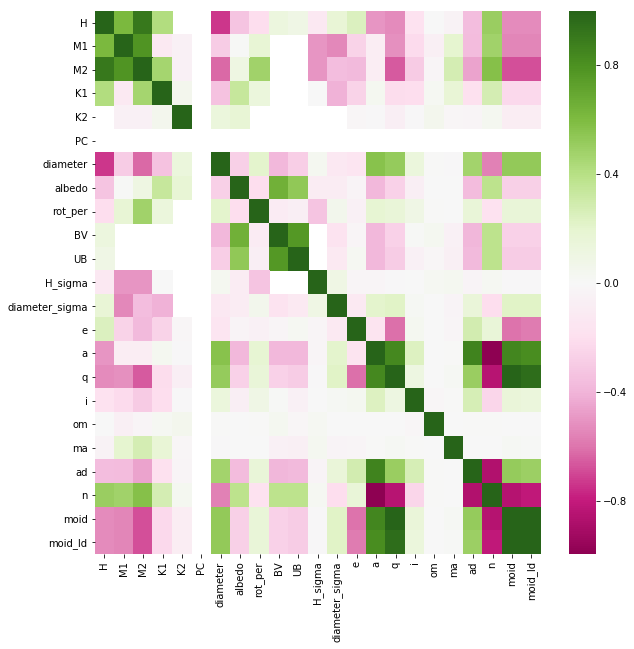

In [7]:
corr = NEO_df.corr(method='spearman')
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='PiYG')

Onto dealing with missing values

## Handling Missing Values

Text(0.5, 0, 'Column Name')

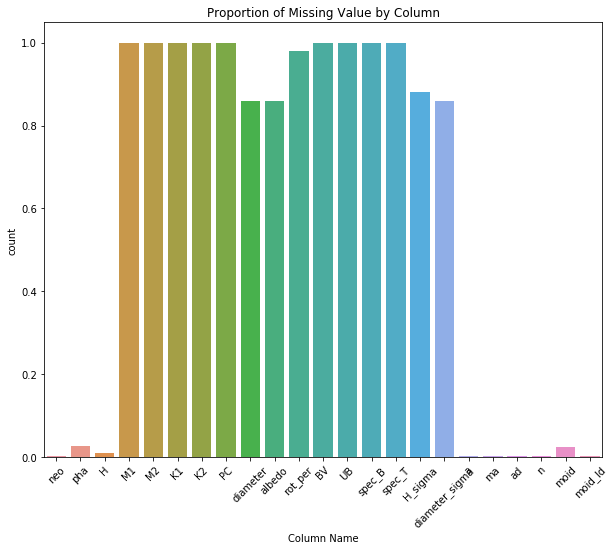

In [8]:
missing_vals = pd.DataFrame(NEO_df.isna().sum())
missing_vals = missing_vals[missing_vals>0].dropna()
missing_vals.columns = ['count']


fit = plt.figure(figsize = (10,8))
sns.barplot(x=missing_vals.index, y=missing_vals['count']/NEO_df.shape[0]);
plt.xticks(rotation=45);
plt.title('Proportion of Missing Value by Column');
plt.xlabel('Column Name')


Unfortunately, there's a lot of missing data. I will first start by dropping the columns where nearly all of it is missing as it would be hard to impute the missing values in these columns. I still want to hold on to diameter as I think it will still be useful in generating predictions. I'm just going to drop the rows where there is no diameter.

In [9]:
NEO_df.drop(['M1', 'M2', 'K1', 'K2', 'PC', 'albedo', 'rot_per', 'BV', 'UB', 'spec_B', 'spec_T', 'H_sigma', 'diameter_sigma'], axis=1, inplace=True)
NEO_df.dropna(axis='rows', subset=['diameter', 'H','pha','neo'], inplace=True)

In [10]:
NEO_df.isna().sum()

neo         0
pha         0
H           0
diameter    0
e           0
a           0
q           0
i           0
om          0
ma          0
ad          0
n           0
moid        0
moid_ld     0
dtype: int64

Taking a look at the missing values again after dropping the most aggregious offenders.

#### NEED TO IMPUTE

Since H is the abolute magnitude (An asteroid's absolute magnitude is the visual magnitude an observer would record if the asteroid were placed 1 Astronomical Unit (au) away, and 1 au from the Sun and at a zero phase angle.), I do not want to impute the average since it is related to the size of an object. For example, a very large object would not have a small H. I am going to use KNNImputer to help impute values.

## Scaling and Transformation 

In [11]:
NEO_df.skew()

H            -0.687406
diameter     25.560631
e             1.416198
a           172.872547
q             7.389582
i             1.713540
om            0.189922
ma           -0.071838
ad          196.490938
n             6.286695
moid          7.673524
moid_ld       7.673524
dtype: float64

It looks like nearly all of the the features exhibit substantial skew and must be transformed ($|feature|>0.5$. The only exceptions are 'om' and 'ma' that are approximately normally distributed since their skew is less. Using the boxcox transformation in conjunction with the ss.boxcox_normmax function will choose the best power transformation that best approximates the normal distribution. Adding 1 to the values allows us to avoid any issues with undefined values in our transformation function such as $log(0)$.

In [12]:
skewed_feats = ['H', 'diameter', 'e', 'a', 'q', 'i', 'ad', 'n', 'moid', 'moid_ld']
skews_boxcox = []

for i in skewed_feats:
    skews_boxcox.append(boxcox1p(NEO_df[i],ss.boxcox_normmax(NEO_df[i]+1)).skew())
    NEO_df[i] = boxcox1p(NEO_df[i],ss.boxcox_normmax(NEO_df[i]+1))

Inspecting the transformed data

Non-Transformed Data


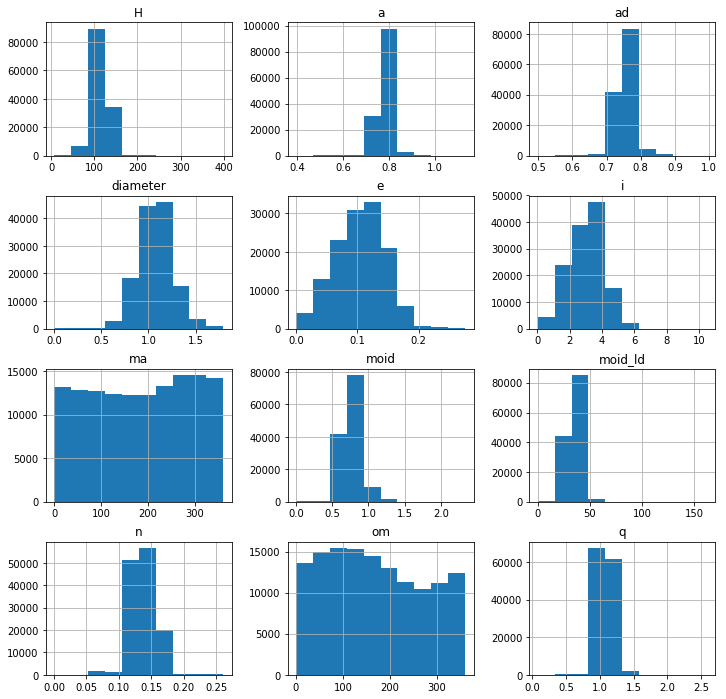

Transformed Data


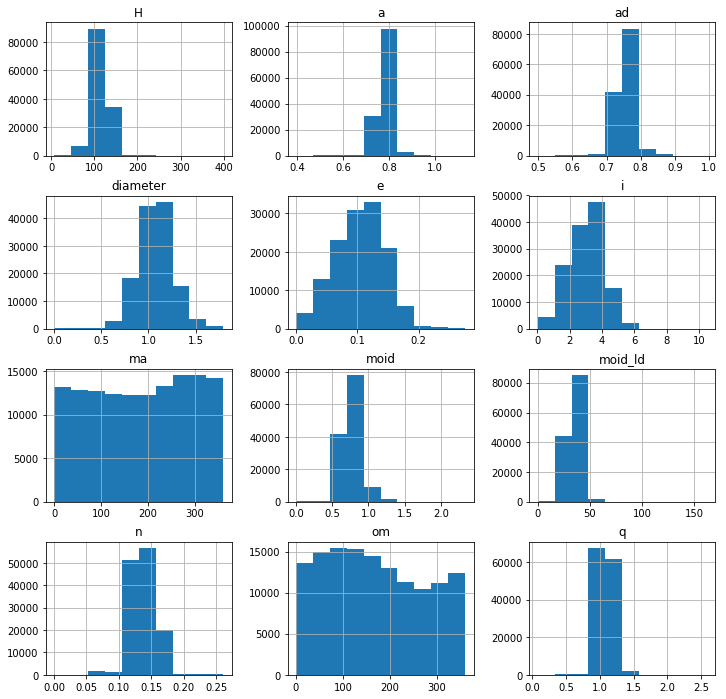

In [13]:
print("Non-Transformed Data")
NEO_df.hist(figsize=(12,12));
plt.show()

print("Transformed Data")
NEO_df.hist(figsize=(12,12));

Comparing the charts above, it looks like the transformation did a pretty good job at normalizing the data. You can also see the new skew values below. 'moid_ld' could be transformed better, but since the skew is less than 0.5 and is only mildly skewed, I think it is OK to leave it alone for this analysis.

In [14]:
NEO_df.skew()

H           0.029815
diameter   -0.036465
e          -0.005722
a          -0.243398
q          -0.012784
i          -0.013823
om          0.189922
ma         -0.071838
ad         -0.169642
n          -0.211398
moid       -0.068454
moid_ld     0.391619
dtype: float64

For my first model I am going to attempt to classify an asteroid as potentially hazardous or not. Since my dataset is very imbalanced I will likely implement bootstrapping (sampling with replacement) to better compensate for the lack of observations where pha='Y'.

In [15]:
X = NEO_df.loc[:, NEO_df.columns != 'pha']
y = NEO_df.loc[:, NEO_df.columns == 'pha']

print(X.shape)
print(y.shape)

(132045, 13)
(132045, 1)


In [16]:
lab_encode = LabelEncoder()
y_encoded = lab_encode.fit_transform(y.values.ravel())
y_encoded = pd.DataFrame(y_encoded, columns= y.columns)

### Training and Model Evaluation

In [17]:
X = pd.get_dummies(X).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 2)

It is important to note that accuracy_score for highly imbalanced datasets has little meaning. For example, if I guessed that every near earth object was not hazardous I would have an accuracy of nearly 100%.

In [18]:
dummy_acc = sum(NEO_df['pha'] == 'N')/NEO_df.shape[0]
print("Accuracy for guessing that every object is not hazardous:", dummy_acc)

Accuracy for guessing that every object is not hazardous: 0.9983339013215192


Not a surprise given how imbalanced the dataset is. Looking at a confusion matrix and other metrics will help us evaluate our model.

In [19]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns) #dataframe must be encoded in order to scale data
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [20]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())
preds_rf = rf.predict(X_test)

confusion_matrix(preds_rf, y_test)

array([[26378,     0],
       [    0,    31]], dtype=int64)

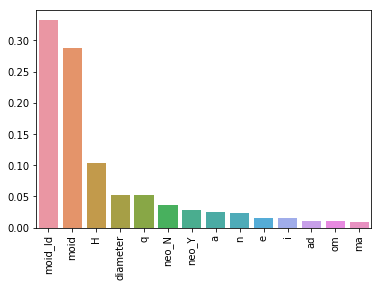

In [21]:
importances_rf = pd.Series(data=rf.feature_importances_,
                        index= X.columns)
importances_rf = importances_rf.sort_values(ascending=False)[:20]
sns.barplot(x=importances_rf.index, y=importances_rf)
plt.xticks(rotation=90)
plt.show()

I think using the MOID columns make the prediction far too easy at it is the Minimum Orbit Intersection Distance that primarily determines whether an asteroid is potentially hazardous (as noted here: https://cneos.jpl.nasa.gov/about/neo_groups.html). I'm curious how my model would perform if we removed these features.

In [22]:
X_noMOID = X.drop(['moid','moid_ld'], axis=1)

In [23]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_noMOID, y_encoded, test_size = 0.2, random_state = 2)

In [26]:
scaler2 = RobustScaler()
X_train2 = pd.DataFrame(scaler2.fit_transform(X_train2), columns = X_noMOID.columns) #dataframe must be encoded in order to scale data
X_test2 = pd.DataFrame(scaler2.transform(X_test2), columns = X_noMOID.columns)

In [27]:
rf_noMOID = RandomForestClassifier()
rf_noMOID.fit(X_train2, y_train2.values.ravel())
preds_rf_noMOID = rf_noMOID.predict(X_test2)

conf_matrix = confusion_matrix(preds_rf_noMOID, y_test2)
NPV = conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[0,1])
print("Negative Predictive Value:" , NPV)

Negative Predictive Value: 0.5161290322580645


Yikes! I would hope NASA's models would be better than this one!

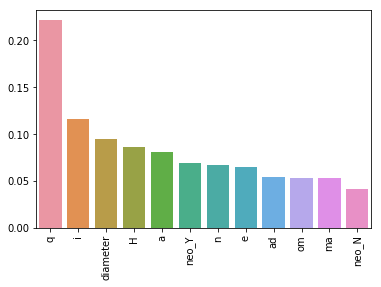

In [28]:
importances_rf_noMOID = pd.Series(data=rf_noMOID.feature_importances_,
                        index= X_noMOID.columns)
importances_rf_noMOID = importances_rf_noMOID.sort_values(ascending=False)[:20]
sns.barplot(x=importances_rf_noMOID.index, y=importances_rf_noMOID)
plt.xticks(rotation=90)
plt.show()

The importances make some intuitive sense as q in the periphelion distance (closest approach to the sun) and i is the inclination of the orbit. If the aphelion, perihelion, and inclination matched that of Earth, the orbits would be identical. Small deviations from these parameters would likely result in potential for collision as an asteroid would cross Earth's path. Additionally, the diameter would dictate the potential damage an asteroid could inflict.

Next Let's see if we can improve on our predictions with bootstrapping.

In [29]:
#Using the strategy shown in https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/ to oversample

oversample = RandomOverSampler(sampling_strategy='minority', random_state=2)
X_over, y_over = oversample.fit_resample(X_train2, y_train2)

In [30]:
rf_noMOID = RandomForestClassifier()
rf_noMOID.fit(X_over, y_over.values.ravel())
preds_rf_noMOID = rf_noMOID.predict(X_test2)

conf_matrix = confusion_matrix(preds_rf_noMOID, y_test2)
NPV = conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[0,1])
print("Negative Predictive Value:" , NPV)
confusion_matrix(preds_rf_noMOID, y_test2)

Negative Predictive Value: 0.6774193548387096


array([[26361,    10],
       [   17,    21]], dtype=int64)

Not perfect, but a good bit better than before. I could do some hyperparamter tuning to obtain better results, but I'm going to try to use a different algorithm to see if if I can do better first.

In [31]:
svc = SVC()
svc.fit(X_over,  y_over.values.ravel())
preds_svc = svc.predict(X_test2)
conf_matrix_svc = confusion_matrix(preds_svc, y_test2)
NPV_svc = conf_matrix_svc[1,1]/(conf_matrix_svc[1,1] + conf_matrix_svc[0,1])

print("Negative Predictive Value:" , NPV_svc)
confusion_matrix(preds_svc, y_test2)

Negative Predictive Value: 0.967741935483871


array([[26288,     1],
       [   90,    30]], dtype=int64)

Not ideal to miss something like a potentially hazardous asteroid, but we only got 1 misclassification for hazardous asteroids!